# Training GPT-3 with language feedback

# Imports

In [1]:
#hide
!pip install wandb
!pip install openai
!pip install datasets
!pip install --upgrade openai wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 181 kB 51.2 MB/s 
     |████████████████████████████████| 147 kB 53.1 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=2453497f54d9f40504519604dfaf7a577f8faead5a77dd3fad3cf7ff74990af1
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 703 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163 kB 8.0 MB/s 
  Created wheel for openai: filename=openai

In [63]:
import pandas as pd
import openai
from datasets import load_dataset
import os
import string
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from typing import List
# from collections import Counter
# from tenacity import retry, wait_random_exponential, stop_after_attempt
 
# from pathlib import Path

**WARNING: Remove the API key after running the cell and clear output so it does not get logged to wandb in case you sync code (see settings)**

In [ ]:
# Enter credentials
%env OPENAI_API_KEY=

In [7]:
openai.api_key = os.getenv("OPENAI_API_KEY")

# Understand the original datasets

Let's have a look at the dataset the authors used to see what it is that we want to replicate.

## Initial summaries

In [9]:
initial_summaries = load_dataset('json', data_files=['data/language_feedback_learning_dataset/finetuning/original_summary_train.jsonl'])['train']

Using custom data configuration default-c3bdbcc1a6d36950


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 124.96it/s]


Dataset json downloaded and prepared to C:\Users\Win 10\.cache\huggingface\datasets\json\default-c3bdbcc1a6d36950\0.0.0\da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


We can see that the `prompt` contains:
- Instruction
- Title:
- Text:
- TL;DR:

The prompt was created like so: 

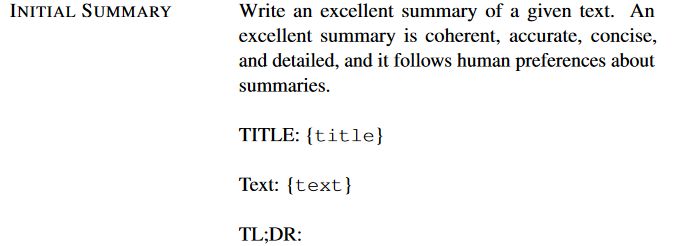

In [10]:
print(initial_summaries['prompt'][0])

Write an excellent summary of a given text. An excellent summary is coherent, accurate, concise, and detailed, and it follows human preferences about summaries.

Title: Friend [25M] is married, but can't get over feelings for me [22F].

Text: I  (22f) was briefly enrolled in a graduate program this fall, and am still in close contact with a lot of friends I made while I was there.  One of these friends is a 25 year old guy from China.  

Because English was not his first language and I could tell he was a little isolated, I was careful to be nice and invite him to events.  We started hanging out some on our own, but mostly just to discuss school/world politics; nothing too personal.  He asked me out a few times this fall, and even though I assumed he was single, I turned him down nicely-- just wasn't interested.

After the final time I turned him down he got a little clingy and weird, so I tried to create some space between us; I didn't really speak to him over Christmas break.

Imagin

The `completion` is the initial summary the model produces

In [11]:
print(initial_summaries['completion'][0])

 My friend from school who is now married is still in love with me and I don't know what to do about it.


## Summaries and Feedback

All of the above data can be gathered and a human can provide feedback on the initial summary.

You can see the result below.

This is the intermediary step that gets us from the original summary to the summaries created after feedback (refinements). 

In [13]:
df = pd.read_csv('data/language_feedback_learning_dataset/refinements/summaries_and_feedback.csv')
df.head(2)

,id,post,title,subreddit,prompt,summary,feedback
0,t3_18tffu,I (22f) was briefly enrolled in a graduate pr...,"Friend [25M] is married, but can't get over fe...",relationships,Write an excellent summary of a given text. An...,My friend from school who is now married is st...,"This summary is good overall, it should howeve..."
1,t3_3aegv4,"We've been dating for 4 months, but we knew ea...",Me [34/F] got frustrated with my boyfriend [34...,relationship_advice,Write an excellent summary of a given text. An...,A woman discusses her frustration with her boy...,"This summary is good, it should however point ..."


## Summaries after feedback (refinements)

In this file we can see the refinements. That is, the summaries produced after the model has been given feedback on it's `initial summary`.

The refinements were obtained with the following prompt:

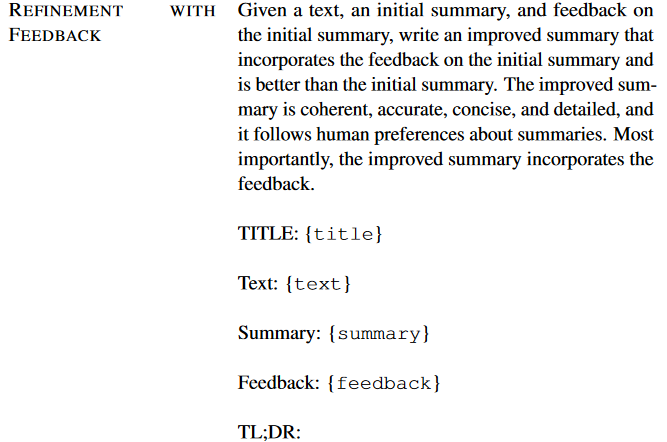

**Important Note:**

The `prompt` in the `feedback_refinement_train.jsonl` file does not look like the prompt used to obtain the `refinement with feedback`.

The `prompt` rather resembles the structure found in the `initial summaries`prompt. 

Concretely, this means, that the `Summary:` and `Feedback:` are not included in the prompt. 

This might seem odd at first, but it makes sense if you think about what the data will look like at test time. 

During training we have access to both the `summary` and the `feedback`.
This is not the case during testing where you only have access to the `instruction`, `title` and `text`.

In [15]:
feedback_refinement = load_dataset('json', data_files=['data/language_feedback_learning_dataset/finetuning/feedback_refinement_train.jsonl'])['train']

Using custom data configuration default-b024b969e6b46173


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 142.42it/s]


Dataset json downloaded and prepared to C:\Users\Win 10\.cache\huggingface\datasets\json\default-b024b969e6b46173\0.0.0\da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 200.52it/s]


In [16]:
print(feedback_refinement['prompt'][0])

Write an excellent summary of a given text. An excellent summary is coherent, accurate, concise, and detailed, and it follows human preferences about summaries.

Title: Friend [25M] is married, but can't get over feelings for me [22F].

Text: I  (22f) was briefly enrolled in a graduate program this fall, and am still in close contact with a lot of friends I made while I was there.  One of these friends is a 25 year old guy from China.  

Because English was not his first language and I could tell he was a little isolated, I was careful to be nice and invite him to events.  We started hanging out some on our own, but mostly just to discuss school/world politics; nothing too personal.  He asked me out a few times this fall, and even though I assumed he was single, I turned him down nicely-- just wasn't interested.

After the final time I turned him down he got a little clingy and weird, so I tried to create some space between us; I didn't really speak to him over Christmas break.

Imagin

In [17]:
print(feedback_refinement['completion'][0])

 My friend from school who is now married is still in love with me and I don't know what to do about it. He's jealous of the guy I've been dating and I feel guilty for trying to cut things off.


# Replicate the algorithm

Ok, now that we know how the data looks like we can start replicating the results.

I will walk through the algorithm with a single example such that the main idea will be conveyed while keeping the code easy to understand.

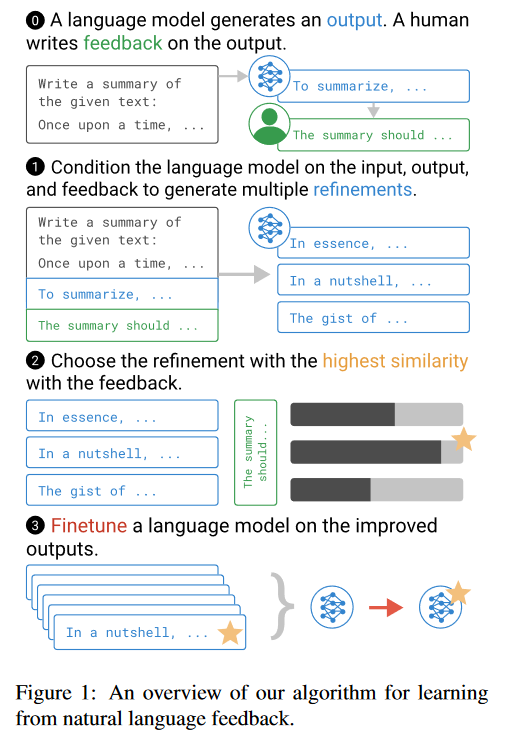

## **`0`**: A language model generates an output. A human writes feedback on the output.

Let's get our model to generate the `initial summaries`.

To do so we have to create an appropriate prompt. It will look like so:


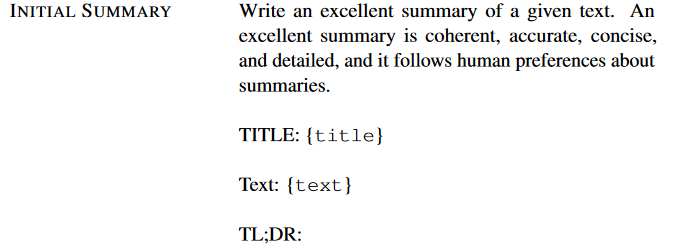

Let's reuse the data from the `summaries_and_feedback.csv` file. 

We can take one example and use it to exemplify the pipeline.

In [19]:
df.head(1)

,id,post,title,subreddit,prompt,summary,feedback
0,t3_18tffu,I (22f) was briefly enrolled in a graduate pr...,"Friend [25M] is married, but can't get over fe...",relationships,Write an excellent summary of a given text. An...,My friend from school who is now married is st...,"This summary is good overall, it should howeve..."


This is what we're aiming for: 

In [20]:
print(df['prompt'][0])

Write an excellent summary of a given text. An excellent summary is coherent, accurate, concise, and detailed, and it follows human preferences about summaries.

Title: Friend [25M] is married, but can't get over feelings for me [22F].

Text: I  (22f) was briefly enrolled in a graduate program this fall, and am still in close contact with a lot of friends I made while I was there.  One of these friends is a 25 year old guy from China.  

Because English was not his first language and I could tell he was a little isolated, I was careful to be nice and invite him to events.  We started hanging out some on our own, but mostly just to discuss school/world politics; nothing too personal.  He asked me out a few times this fall, and even though I assumed he was single, I turned him down nicely-- just wasn't interested.

After the final time I turned him down he got a little clingy and weird, so I tried to create some space between us; I didn't really speak to him over Christmas break.

Imagin

In [21]:
def generate_prompt(instructions, title, text):
  prompt = instructions + "\n\nTitle: " + title + "\n\nText: " + text + '\n\nTL;DR'
  return prompt

In [22]:
instructions = "Write an excellent summary of a given text. An excellent summary is coherent, accurate, concise, and detailed, and it follows human preferences about summaries."
title = df['title'][0] 
text = df['post'][0]

prompt = generate_prompt(instructions, title, text)
print(prompt)

Write an excellent summary of a given text. An excellent summary is coherent, accurate, concise, and detailed, and it follows human preferences about summaries.

Title: Friend [25M] is married, but can't get over feelings for me [22F].

Text: I  (22f) was briefly enrolled in a graduate program this fall, and am still in close contact with a lot of friends I made while I was there.  One of these friends is a 25 year old guy from China.  

Because English was not his first language and I could tell he was a little isolated, I was careful to be nice and invite him to events.  We started hanging out some on our own, but mostly just to discuss school/world politics; nothing too personal.  He asked me out a few times this fall, and even though I assumed he was single, I turned him down nicely-- just wasn't interested.

After the final time I turned him down he got a little clingy and weird, so I tried to create some space between us; I didn't really speak to him over Christmas break.

Imagin

Let's have a look at whether the prompts are identical

In [23]:
prompt == df['prompt'][0]

True

Great, now that we know how the prompt is generated, we can generate an output: our `initial summary`.




From the paper we get some useful information: 
> We take 100 samples from the **Reddit data subset** used in Stiennon et al. (2020). We use **InstructGPT (175B)** to generate initial summaries and refinements, using the instructions in Appendix F. We then write feedback f on the initial summary y given the Reddit post x, and we generate possible refinements $y′_{1}$, . . . , $y′_{20}$.


In **Appendix E.1** we find more on how to generate the desired outputs:
> *For all summarization experiments (§3.2), we sample up to **48 tokens** (as in Stiennon et al., 2020) with **nucleus sampling** (Holtzman et al., 2019) with **p = 0.9**. We **strip nonalphanumeric characters** (e.g., newlines) from the beginning of sampled summaries. Due to the maximum token length, sampled summaries sometimes end with an incomplete sentence. Thus, we remove ending sentences that do not end in “.”, “!”, or “?”*

To summarize:
- model: 'InstructGPT (175B)' -> `text-davinci-001`
- max_tokens: 48
- sampling: 'nucleus sampling with p=0.9' -> `top_p=0.9`
- number of generations for refinements: 20 -> `n=20`
- number of generations for initial summary: 1 -> `n=1`
- remove newline characters from beginning of summary
- remove summaries if they are incomplete sentences

The resulting call to the OpenAI API looks like this

```python
model_output_choices = openai.Completion.create(
  model="text-davinci-001",
  prompt=input_text,
  max_tokens=48,
  top_p=0.9,
  n=1) # n=20 for refinement generation
```

In [48]:
initial_summary_output = openai.Completion.create(
  model="text-davinci-001",
  prompt=prompt,
  max_tokens=48,
  top_p=0.9,
  n=1,
  stop='\n')

In [49]:
initial_summary = initial_summary_output['choices'][0]['text'] 
initial_summary

' Friend from graduate program married, now has feelings for friend; what should she do?'

Let's perform the remaining 2 processing steps
- remove newline characters from beginning of summary
- remove summaries if they are incomplete sentences

In [50]:
# Remove non alpha numeric characters
string.whitespace + string.punctuation

' \t\n\r\x0b\x0c!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [51]:
proccessed_summary = initial_summary.lstrip(string.whitespace + string.punctuation)
proccessed_summary

'Friend from graduate program married, now has feelings for friend; what should she do?'

Since our summary ends with one of the valid signs we don't need to prduce another summary.

In [52]:
valid_end_signs = ('.', '!', '?')
proccessed_summary.endswith(valid_end_signs)

True

As a last task in step **`0`** a human writes feedback on the output.

- We could write this ourselves, but I think the main gist is clear. 
- The main point is that this step is performed manually by humans and can therefore be quite costly. 
- We'll therefore just use the feedback from the dataset

In [53]:
feedback = df['feedback'][0]
feedback

'This summary is good overall, it should however mention that her friend from graduate school does not have many friends and that she feels guilty for trying to cut things off. Also her friend puts a lot of energy in maintaining contact with the author. The summary should also convey that the author is asking for advice on what to do about this. '

## **`1`** Condition the language model on the input, output, and feedback to generate multiple refinements.

Now that we have created an initial summary and tasked humans to provide written feedback on them, we can prompt the model again to create `refinements`

We can reuse our prompt creation function and modify it a little.

In [54]:
def generate_prompt(instructions, title, text, 
                    is_refinement=False, summary=None, feedback=None):
  if is_refinement:
    prompt = instructions + "\n\nTitle: " + title + "\n\nText: " + text + '\n\nSummary:' + summary + '\n\nFeedback:' + feedback + '\n\nTL;DR' 
  else:
    prompt = instructions + "\n\nTitle: " + title + "\n\nText: " + text + '\n\nTL;DR'
  return prompt

In [55]:
refinement_instructions = """Given a text, an initial summary, and feedback on 
the initial summary, write an improved summary that incorporates the feedback 
on the initial summary and is better than the initial summary. 
The improved summary is coherent, accurate, concise, and detailed, and it 
follows human preferences about summaries. Most importantly, the improved 
summary incorporates the feedback.
"""
refinement_prompt = generate_prompt(refinement_instructions,
                                    title,
                                    text,
                                    is_refinement=True,
                                    summary=proccessed_summary,
                                    feedback=feedback
                                    )

We can use the new prompt to get 20 refinements.

In [56]:
model_output_choices = openai.Completion.create(
  model="text-davinci-001",
  prompt=refinement_prompt,
  max_tokens=48,
  top_p=0.9,
  n=20)

Congrats, you've just generated 20 refinements

In [68]:
refinements = pd.DataFrame(model_output_choices['choices'])[['text']]
refinements

,text
0,:\n\nThe author has a friend from their gradua...
1,:\n\nThe author's friend from graduate school ...
2,: \n\nThe author's friend from graduate school...
3,: The author has a friend from graduate school...
4,: \n\nThe author is in close contact with a lo...
5,:\n\nThe author has a friend from graduate sch...
6,: \n\nThe author has a friend from graduate sc...
7,: \n\nThe author has a friend from graduate sc...
8,: \n\nThe author has a friend from their gradu...
9,: \n\nThe author has a friend from graduate sc...


Let's perform the remaining 2 processing steps
- remove newline characters from beginning of summary
- remove summaries if they are incomplete sentences

In [75]:
def postprocess_refinements(refinements, valid_end_signs=('!', '.', '?')):
  # This function works on dataframes
  refinements['text'] = refinements['text'].apply(lambda x: x.lstrip(string.whitespace + string.punctuation))
  refinements['text'] = refinements['text'].apply(lambda x: x if x.endswith(valid_end_signs) else '')
  refinements['text'].replace('', np.nan, inplace=True)
  refinements['text'].dropna(inplace=True)
  return refinements

In [76]:
refinements_df = postprocess_refinements(refinements)
refinements_df

,text
0,The author has a friend from their graduate pr...
1,The author's friend from graduate school is ma...
3,The author has a friend from graduate school w...
5,The author has a friend from graduate school w...
7,The author has a friend from graduate school w...
8,The author has a friend from their graduate pr...
9,The author has a friend from graduate school w...
11,The author has a friend from graduate school w...
13,The author has a friend from graduate school w...
14,The author has a friend from graduate school w...


## **`2`** Choose the refinement with the **highest similarity** with the feedback

With the refinements in hand we can check which one has the highest similarity with our feedback and then save it as the one we'll finetune our model on.

We start by creating the `get_embedding` function.

It uses the `openai.Embedding` endpoint which is a contrastive pre-trained text embedding function.

In [77]:
# @retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_embedding(text: str, engine="text-similarity-davinci-001") -> List[float]:

    # replace newlines, which can negatively affect performance.
    text = text.replace("\n", " ")

    return openai.Embedding.create(input=[text], engine=engine)["data"][0]["embedding"]

print(len(get_embedding("This is a sample query text", engine="text-similarity-babbage-001")))

2048


Get `refinement embeddings` and save them for future reuse

In [83]:
refinements_df['babbage_similarity'] = refinements_df['text'].apply(lambda x: get_embedding(x, engine='text-similarity-babbage-001'))
# refinements_df['babbage_search'] = refinements_df['text'].apply(lambda x: get_embedding(x, engine='text-search-babbage-doc-001'))
refinements_df.to_csv('refinements.csv')

In [84]:
refinements_df.head(2)

,text,babbage_similarity
0,The author has a friend from their graduate pr...,"[0.004192444495856762, 0.015246931463479996, -..."
1,The author's friend from graduate school is ma...,"[0.006996044889092445, 0.01488018874078989, -0..."


In [85]:
len(refinements_df['babbage_similarity'][0])

2048

We use the `sklearn cosine similarity` which expects a list of lists like so.

In [88]:
cosine_similarity([*refinements_df['babbage_similarity']], [*refinements_df['babbage_similarity']])[:5]

array([[1.        , 0.98391286, 0.93524358, 0.93785964, 0.93905301,
        1.        , 0.93785964, 0.93785964, 0.93524358, 0.92771537,
        0.93550934, 0.98391286, 0.98391286, 0.98391286, 0.93785964],
       [0.98391286, 1.        , 0.92949444, 0.93065931, 0.94512564,
        0.98391286, 0.93065931, 0.93065931, 0.92949444, 0.93515841,
        0.92720113, 1.        , 1.        , 1.        , 0.93065931],
       [0.93524358, 0.92949444, 1.        , 0.99801855, 0.95988518,
        0.93524358, 0.99801855, 0.99801855, 1.        , 0.9389564 ,
        0.99811568, 0.92949444, 0.92949444, 0.92949444, 0.99801855],
       [0.93785964, 0.93065931, 0.99801855, 1.        , 0.95893281,
        0.93785964, 1.        , 1.        , 0.99801855, 0.93808102,
        0.99652958, 0.93065931, 0.93065931, 0.93065931, 1.        ],
       [0.93905301, 0.94512564, 0.95988518, 0.95893281, 1.        ,
        0.93905301, 0.95893281, 0.95893281, 0.95988518, 0.98025795,
        0.95766883, 0.94512564, 0.94512564, 

Create function to compare `refinements` and `human feedback`

In [90]:
def compare_refinement_to_human_feedback(refinements_df, human_feedback, n=1):
   embedding = get_embedding(human_feedback, engine='text-similarity-babbage-001')
   refinements_df['similarities'] = refinements_df['babbage_similarity'].apply(lambda x: cosine_similarity([x], [embedding]))
   res = refinements_df.sort_values('similarities', ascending=False).head(n)
   return res
 
res = compare_refinement_to_human_feedback(refinements_df, feedback, n=3)

In [91]:
res

,text,babbage_similarity,similarities
5,The author has a friend from graduate school w...,"[0.0005159178399480879, 0.00046537088928744197...",[[0.8158968234048924]]
9,The author has a friend from graduate school w...,"[0.0005159178399480879, 0.00046537088928744197...",[[0.8158968234048924]]
11,The author has a friend from graduate school w...,"[0.0005159178399480879, 0.00046537088928744197...",[[0.8158968234048924]]


Pick refinement with **highest similarity**

In [92]:
improved_output = res.iloc[0]['text']
print(improved_output)

The author has a friend from graduate school who is married but has feelings for her. The author is asking for advice on what to do about this situation.


Now we have essentially replicated all the necessary steps to arrive at the `feedback_refinement` dataset. 

We'll only need to get our data in the correct jsonl format with a `prompt` and `completion`.

## **`3`** Finetune a language model on the improved outputs


To perform the finetuning we can consult the OpenAI API, which states that: 

> Your dataset must be formatted as a **JSONL file**, where each training example is a JSON object with the **keys "prompt" and "completion"**. Additionally, you must **upload your file with the purpose fine-tune**.

Since we now know how the dataset has been created we can use the `feedback_refinement.jsonl` file for the finetuning.

Let's have a look how the dataset from the paper looks like 

In [98]:
feedback_refinement

Dataset({
    features: ['prompt', 'completion'],
    num_rows: 100
})

In [100]:
print(feedback_refinement[0]['prompt'])

Write an excellent summary of a given text. An excellent summary is coherent, accurate, concise, and detailed, and it follows human preferences about summaries.

Title: Friend [25M] is married, but can't get over feelings for me [22F].

Text: I  (22f) was briefly enrolled in a graduate program this fall, and am still in close contact with a lot of friends I made while I was there.  One of these friends is a 25 year old guy from China.  

Because English was not his first language and I could tell he was a little isolated, I was careful to be nice and invite him to events.  We started hanging out some on our own, but mostly just to discuss school/world politics; nothing too personal.  He asked me out a few times this fall, and even though I assumed he was single, I turned him down nicely-- just wasn't interested.

After the final time I turned him down he got a little clingy and weird, so I tried to create some space between us; I didn't really speak to him over Christmas break.

Imagin

In [102]:
feedback_refinement[0]['completion']

" My friend from school who is now married is still in love with me and I don't know what to do about it. He's jealous of the guy I've been dating and I feel guilty for trying to cut things off."

## Data preparation tool

To prepare your dataset you can use the `finetunes.prepare_data` tool provided by OpenAI. 
The procedure was taken from this [notebook](https://github.com/openai/openai-python/blob/main/examples/finetuning/finetuning-classification.ipynb).

In [103]:
!openai tools fine_tunes.prepare_data -f data/language_feedback_learning_dataset/finetuning/feedback_refinement_train.jsonl -q

Analyzing...

- Your file contains 100 prompt-completion pairs
- All prompts end with suffix `\n\nTL;DR:`
- All prompts start with prefix `Write an excellent summary of a given text. An excellent summary is coherent, accurate, concise, and detailed, and it follows human preferences about summaries.

Title: `. Fine-tuning doesn't require the instruction specifying the task, or a few-shot example scenario. Most of the time you should only add the input data into the prompt, and the desired output into the completion
- Your data does not contain a common ending at the end of your completions. Having a common ending string appended to the end of the completion makes it clearer to the fine-tuned model where the completion should end. See https://beta.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples.

Based on the analysis we will perform the following actions:
- [Recommended] Remove prefix `Write an excellent summary of a given text. An excellent summar

After having prepared the dataset, we can perform the fine-tuning. 

To replicate the exact results from the paper we would use the model `davinci`.

That can get quite expensive though, so I opted for the cheaper `ada` model which brings the point home just as much.

Copy the path to the `modified file` and voila.

In [106]:
!openai api fine_tunes.create -t data/language_feedback_learning_dataset/finetuning/feedback_refinement_train_prepared.jsonl -m ada

Uploaded file from data/language_feedback_learning_dataset/finetuning/feedback_refinement_train_prepared.jsonl: file-EhRY9iXC2WRION3J6TpF8BXx
Created fine-tune: ft-kkNf0oWN77w7uhOz9sefREIG
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2022-07-19 21:25:28] Created fine-tune: ft-kkNf0oWN77w7uhOz9sefREIG
[2022-07-19 21:25:40] Fine-tune costs $0.06
[2022-07-19 21:25:40] Fine-tune enqueued. Queue number: 0
[2022-07-19 21:25:45] Fine-tune started
[2022-07-19 21:26:13] Completed epoch 1/4
[2022-07-19 21:26:28] Completed epoch 2/4
[2022-07-19 21:26:42] Completed epoch 3/4
[2022-07-19 21:26:57] Completed epoch 4/4
[2022-07-19 21:27:17] Uploaded model: ada:ft-academicsnyuperez-2022-07-19-19-27-17
[2022-07-19 21:27:18] Uploaded result file: file-XlXM6HnYgcuxHbSgFnqtX5f2
[2022-07-19 21:27:18] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m ada:ft-academicsn


Upload progress:   0%|          | 0.00/157k [00:00<?, ?it/s]
Upload progress: 100%|██████████| 157k/157k [00:00<00:00, 154Mit/s]


The fine-tune cost us $0.06.

Let's see how we can use the model for inference.

For a quick sanity check we can reuse the prompt from above. 

In [107]:
openai.Completion.create(
  model="ada:ft-academicsnyuperez-2022-07-19-19-27-17",
  prompt=prompt,
  max_tokens=48,
  top_p=0.9,
  n=1)

<OpenAIObject text_completion id=cmpl-5VnCm7IbpGKNsLGp3R5t0IU18m1GX at 0x1c7e12fd3a0> JSON: {
  "choices": [
    {
      "finish_reason": "length",
      "index": 0,
      "logprobs": null,
      "text": ": The author is trying to get a friend back from a relationship because he is afraid that if he does not break things, his friend may find out. The friend is jealously over the author's new friend and the author is unsure"
    }
  ],
  "created": 1658258996,
  "id": "cmpl-5VnCm7IbpGKNsLGp3R5t0IU18m1GX",
  "model": "ada:ft-academicsnyuperez-2022-07-19-19-27-17",
  "object": "text_completion",
  "usage": {
    "completion_tokens": 48,
    "prompt_tokens": 459,
    "total_tokens": 507
  }
}